<a href="https://www.kaggle.com/code/aleksandrmorozov123/rt-detr-inference?scriptVersionId=224058790" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/volleyball-ball-object-detection-dataset/README.dataset.txt
/kaggle/input/volleyball-ball-object-detection-dataset/README.roboflow.txt
/kaggle/input/volleyball-ball-object-detection-dataset/data.yaml
/kaggle/input/volleyball-ball-object-detection-dataset/valid/labels/clip_two_mp4-0196_jpg.rf.64cb9c0c3619e01eff7fd9aa894f70a7.txt
/kaggle/input/volleyball-ball-object-detection-dataset/valid/labels/clip_two_mp4-0017_jpg.rf.fb1f026cb300cf495591dd40c59b9f87.txt
/kaggle/input/volleyball-ball-object-detection-dataset/valid/labels/clip_four_mp4-0032_jpg.rf.e21eb2efba5101dbf10079c83084fcae.txt
/kaggle/input/volleyball-ball-object-detection-dataset/valid/labels/clip_four_mp4-0173_jpg.rf.0acd051c1e019402621ca7a564d64cd8.txt
/kaggle/input/volleyball-ball-object-detection-dataset/valid/labels/clip_two_mp4-0186_jpg.rf.1cb15f0d74534b97ead27d47a31ce268.txt
/kaggle/input/volleyball-ball-object-detection-dataset/valid/labels/clip_three_mp4-0189_jpg.rf.fdfe1a089937bbe1f7d76174cbb0f411.txt
/k

**RT-DETR**, short for "Real-Time DEtection TRansformer", is a computer vision model developed by the Peking University and Baidu.

In [2]:
# install dependencies

!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q git+https://github.com/roboflow/supervision.git
!pip install -q roboflow
!pip install -q accelerate 
!pip install -q torchmetrics
!pip install -q "albumentations>=1.4.5"

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.


In [3]:
# import required libraries

import torch
import requests

import numpy as np
import supervision as sv
import albumentations as A

from PIL import Image
from pprint import pprint
from roboflow import Roboflow
from dataclasses import dataclass, replace
from torch.utils.data import Dataset
from transformers import AutoImageProcessor, AutoModelForObjectDetection, TrainingArguments, Trainer
from torchmetrics.detection.mean_ap import MeanAveragePrecision

**Infrence with the pre-trained RT-DETR model**

In [4]:
CHECKPOINT = "PekingU/rtdetr_r50vd_coco_o365"
DEVICE = torch.device ("cuda" if torch.cuda.is_available () else "cpu")

model = AutoModelForObjectDetection.from_pretrained (CHECKPOINT).to (DEVICE)
processor = AutoImageProcessor.from_pretrained (CHECKPOINT)

config.json:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].


preprocessor_config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:
img = "/kaggle/input/volleyball-ball-object-detection-dataset/train/images/clip_four_mp4-0015_jpg.rf.5439f7aa49492bb5c646aa6a749fffe6.jpg"

image = Image.open (img)
inputs = processor (image, return_tensors = "pt").to (DEVICE)

with torch.no_grad ():
    outputs = model (**inputs)

w, h = image.size
results = processor.post_process_object_detection (
    outputs, target_sizes = [(h, w)], threshold = 0.3)

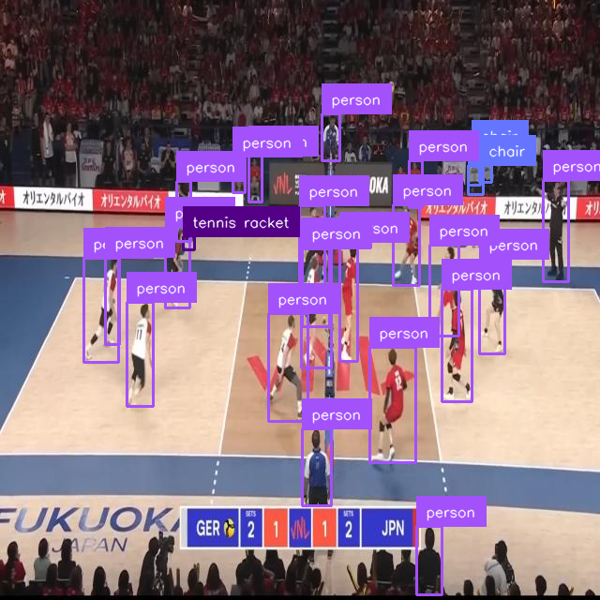

In [6]:
detections = sv.Detections.from_transformers (results [0])
labels = [
    model.config.id2label [class_id]
    for class_id 
    in detections.class_id
]

annotated_image = image.copy ()
annotated_image = sv.BoxAnnotator().annotate(annotated_image, detections)
annotated_image = sv.LabelAnnotator ().annotate (annotated_image, detections, labels = labels)
annotated_image.thumbnail ((600, 600))
annotated_image